<a href="https://colab.research.google.com/github/vitostamatti/deep-rec/blob/main/examples/movies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movies Recommendation Example


In [15]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [4]:
!git clone https://github.com/vitostamatti/deep-rec.git

Cloning into 'deep-rec'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 40 (delta 11), reused 32 (delta 9), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [5]:
!pip install ./deep-rec/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./deep-rec
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for deeprec: filename=deeprec-0.0-py3-none-any.whl size=6441 sha256=0b1fe8dc2f34c73d5635e7c5d2ebf407af387ede646df2cadcb43b0f5d9cf01c
  Stored in directory: /root/.cache/pip/wheels/d7/e6/f1/535adb0dc5bb78faa214a44ed311cfaa1821f7ba83a90bf8cc
Successfully built deeprec


In [13]:
# !wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
# !unzip ml-latest-small.zip
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

--2022-12-27 08:02:51--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  30.1MB/s    in 0.2s    

2022-12-27 08:02:52 (30.1 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.ba

In [6]:
from deeprec.dataset import RecDataset
from deeprec.model import RecModel

In [17]:
BASE_DATA_PATH = './ml-100k/'


interactions = pd.read_csv(
    os.path.join(BASE_DATA_PATH, "u.data"),
    sep="\t",
    names = ['user_id','item_id','rating','timestamp']
)


items = pd.read_csv(
    os.path.join(BASE_DATA_PATH, "u.item"),
    sep="|",
    encoding='latin-1',
    names = ["item_id", "title", "release_date", "video_release_date",
              "IMDb_URL", "unknown", "Action", "Adventure", "Animation",
              "Childrens", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
              "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
              "Thriller", "War", "Western"
            ]
)


users = pd.read_csv(
    os.path.join(BASE_DATA_PATH, "u.user"),
    sep="|",
    names = ["user_id", "age", "gender", "occupation", "zip_code"]
)


In [18]:
def user_age_catetory_feature(users):
    users['age_cat'] = pd.qcut(
        users['age'], 
        q = 10, 
        labels=[f'age_{i}' for i in range(10)]
    )
    users['age_cat'] = users['age_cat'].astype(str)
    return users


def get_genres_feature(items, genres):
    items["genres"] = ""
    for idx, col in enumerate(genres):
        items[col+"_text"] = items[col].apply(
            lambda x: "|"+ col if x==1 else ""
        )
        items["genres"] = items[col+"_text"] + items["genres"] 
        items = items.drop(columns=f"{col}_text")
        
    items["genres"] = items["genres"]+"|"
    
    return items

def split_genres_feature(items, max_cols=3):
    splitted_genres = items['genres'].str.split(
        '|', expand=True
    ).iloc[:,1:max_cols+1].replace("","unknown").fillna("unknown")
    
    splitted_genres.columns = [f"genres_{i}" for i in range(max_cols)]
    
    return items.join(splitted_genres,how='left')


def items_years_old_feature(items):
    from datetime import datetime
    items['years_old'] = (
        datetime.now() - pd.to_datetime(items['release_date'])
    ).dt.days/365
    
    return items

def items_year_release_feature(items):
    from datetime import datetime
    items['year_release'] = pd.to_datetime(items['release_date']).dt.year
    items['year_release'] = items['year_release'].fillna(items['year_release'].mean())
    items['year_release'] = items['year_release'].astype(int)
    
    return items


def preprocess_users(users):
    users = user_age_catetory_feature(users)
    return users

def preprocess_items(items):
    genres = [
        'unknown', 'Action', 'Adventure', 
        'Animation', 'Childrens', 'Comedy',
        'Crime', 'Documentary', 'Drama', 
        'Fantasy', 'Film-Noir', 'Horror',
        'Musical', 'Mystery', 'Romance', 
        'Sci-Fi', 'Thriller', 'War', 'Western'
    ]
    items = get_genres_feature(items, genres)
    items = items_years_old_feature(items)
    items = items_year_release_feature(items) 
    items = split_genres_feature(items)
    
    return items

In [19]:
items = preprocess_items(items)
users = preprocess_users(users)

In [26]:
from sklearn.model_selection import train_test_split

user_features_names = ['gender','age_cat','occupation']
item_features_names = ['genres_0',"genres_1","genres_2",'year_release']
user_id="user_id"
item_id="item_id" 
users_feat = users.set_index(user_id)[user_features_names]
items_feat = items.set_index(item_id)[item_features_names]

In [27]:
inter_train, inter_test = train_test_split(
    interactions, 
    test_size=0.2,
    stratify=interactions["user_id"]
)

In [29]:
ds = RecDataset(
    user_id=user_id,
    item_id=item_id, 
    target_id="rating"
)
X_train, y_train = ds(
    inter_train, 
    users_feat, 
    items_feat
)
X_test, y_test = ds(
    inter_test, 
    users_feat, 
    items_feat   
)

In [30]:
rec_model = RecModel()

In [38]:
rec_model.build(
    users[user_id],
    items[item_id],
    users_feat,
    items_feat
)

In [39]:
history = rec_model.fit(
    X_train, y_train
)

Epoch 1/20
282/282 - 6s - loss: 10.3039 - val_loss: 8.0334 - 6s/epoch - 20ms/step
Epoch 2/20
282/282 - 3s - loss: 6.2139 - val_loss: 4.6670 - 3s/epoch - 12ms/step
Epoch 3/20
282/282 - 3s - loss: 3.5417 - val_loss: 2.6545 - 3s/epoch - 12ms/step
Epoch 4/20
282/282 - 3s - loss: 2.1204 - val_loss: 1.7490 - 3s/epoch - 12ms/step
Epoch 5/20
282/282 - 3s - loss: 1.5722 - val_loss: 1.4650 - 3s/epoch - 11ms/step
Epoch 6/20
282/282 - 3s - loss: 1.4171 - val_loss: 1.3865 - 3s/epoch - 12ms/step
Epoch 7/20
282/282 - 4s - loss: 1.3652 - val_loss: 1.3481 - 4s/epoch - 12ms/step
Epoch 8/20
282/282 - 4s - loss: 1.3301 - val_loss: 1.3155 - 4s/epoch - 13ms/step
Epoch 9/20
282/282 - 3s - loss: 1.2978 - val_loss: 1.2852 - 3s/epoch - 11ms/step
Epoch 10/20
282/282 - 3s - loss: 1.2670 - val_loss: 1.2566 - 3s/epoch - 11ms/step
Epoch 11/20
282/282 - 3s - loss: 1.2375 - val_loss: 1.2298 - 3s/epoch - 11ms/step
Epoch 12/20
282/282 - 3s - loss: 1.2091 - val_loss: 1.2042 - 3s/epoch - 11ms/step
Epoch 13/20
282/282 - 4s

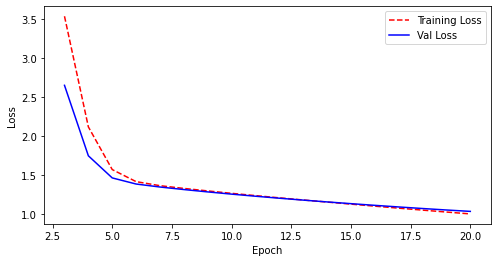

In [40]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count[2:], training_loss[2:], 'r--')
plt.plot(epoch_count[2:], test_loss[2:], 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [41]:
score = rec_model.evaluate(X_test, y_test)
print()
print('RMSE: {:.4f}'.format(np.sqrt(score)))

625/625 [==============================] - 4s 6ms/step - loss: 1.0711

RMSE: 1.0350


In [45]:
results = pd.DataFrame(X_test)
results['y_true'] = y_test

user_preds = rec_model.predict(X_test)

results['y_pred'] = user_preds
results

625/625 [==============================] - 2s 3ms/step


,user_id,item_id,gender,age_cat,occupation,genres_0,genres_1,genres_2,year_release,y_true,y_pred
0,537,660,M,age_6,engineer,Drama,unknown,unknown,1991,3,3.743660
1,655,547,F,age_8,healthcare,Crime,unknown,unknown,1996,4,2.693601
2,840,82,M,age_6,artist,Sci-Fi,Adventure,Action,1993,3,3.836431
3,94,302,M,age_2,student,Thriller,Mystery,Film-Noir,1997,4,4.225177
4,87,576,M,age_8,administrator,Crime,Adventure,Action,1993,3,3.287431
...,...,...,...,...,...,...,...,...,...,...,...
19995,899,31,M,age_5,other,War,Thriller,Drama,1995,3,3.593670
19996,184,692,M,age_6,librarian,Romance,Drama,Comedy,1995,4,3.757826
19997,766,211,M,age_7,other,War,Comedy,unknown,1970,4,4.003128
19998,429,629,M,age_3,student,Musical,Comedy,unknown,1982,3,3.422002


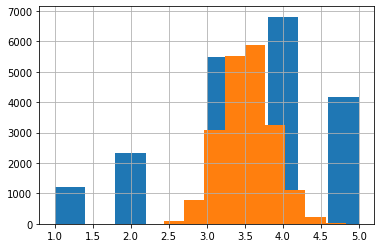

In [46]:
results['y_true'].hist()
results['y_pred'].hist()